# Retriever evaluation: Hybrid

Evaluate if hybrid improves on the previous results.
1. Reciprocal rerank fusion
2. Relative score fusion
3. Distribution-based score fusion

In [1]:
# Setup

import os
import textwrap as tr

import nest_asyncio
from azure.identity import DefaultAzureCredential, ManagedIdentityCredential
from azure.keyvault.secrets import SecretClient
from dotenv import load_dotenv
from llama_index.core import ServiceContext, set_global_service_context
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.core.prompts import ChatMessage, ChatPromptTemplate, MessageRole
from tqdm import tqdm

# This is a hack to get some things to work in Jupyter Notebooks
nest_asyncio.apply()

def pwrap(text):
    print(tr.fill(str(text), width=80))

# Load environment variables from .env file
try:
    load_dotenv(dotenv_path=".env")
except:
    pass

# If we're running on Azure, use the Managed Identity to get the secrets
if os.environ.get("CREDENTIAL_TYPE").lower() == "managed":
    credential = ManagedIdentityCredential()
else:
    credential = DefaultAzureCredential()

# Login to KeyVault using Azure credentials
client = SecretClient(
    vault_url=os.environ.get("AZURE_KEYVAULT_URL"), credential=credential
)

OPENAI_API_BASE = os.environ.get("AZURE_OPENAI_ENDPOINT")
OPENAI_API_VERSION = os.environ.get("AZURE_OPENAI_VERSION")
OPENAI_API_KEY = client.get_secret("OPENAI-SERVICE-KEY").value

api_key = OPENAI_API_KEY
azure_endpoint = OPENAI_API_BASE
api_version = OPENAI_API_VERSION


llm = AzureOpenAI(
    model="gpt-35-turbo",
    deployment_name="gpt-35-turbo",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name="text-embedding-ada-002",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

from llama_index.core import set_global_service_context

service_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model=embed_model,
)

set_global_service_context(service_context)

C:\Users\jkuehn\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jkuehn\AppData\Local\Temp\ipykernel_85560\4010115253.py:67: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


## Generate EmbeddingQAFinetuneDataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('small_df.csv')

df.columns

Index(['section_id', 'doc_id', 'type', 'doc_title_eng', 'doc_title_fra',
       'section_str_eng', 'section_str_fra', 'heading_str_eng',
       'heading_str_fra', 'text_eng', 'text_fra', 'char_cnt_eng',
       'char_cnt_fra', 'token_cnt_eng', 'token_cnt_fra', 'text_combined_eng',
       'text_combined_fra', 'hard_eng_queries', 'easy_eng_queries',
       'easy_fra_queries', 'hard_fra_queries'],
      dtype='object')

In [3]:
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.core.schema import MetadataMode, TextNode
import uuid

eng_nodes = [TextNode(id=row['section_id'], text=row['text_combined_eng']) for index, row in df.iterrows()]
fra_nodes = [TextNode(id=row['section_id'], text=row['text_combined_fra']) for index, row in df.iterrows()]
eng_questions_easy = df['easy_eng_queries'].tolist()
eng_questions_hard = df['hard_eng_queries'].tolist()
fra_questions_easy = df['easy_fra_queries'].tolist()
fra_questions_hard = df['hard_fra_queries'].tolist()

def build_eval_dataset(nodes, questions):
    """Takes nodes and questions: 2 lists of the same length"""
    node_dict = {
        node.node_id: node.get_content(metadata_mode=MetadataMode.NONE)
        for node in nodes
    }
    queries = {}
    relevant_docs = {}

    for node, question in zip(nodes, questions):
        question_id = str(uuid.uuid4())
        queries[question_id] = question
        relevant_docs[question_id] = [node.node_id]

    # construct dataset
    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

# TODO: add multi-language corpus
eng_to_eng_easy = build_eval_dataset(eng_nodes, eng_questions_easy)
eng_to_eng_hard = build_eval_dataset(eng_nodes, eng_questions_hard)
fra_to_fra_easy = build_eval_dataset(fra_nodes, fra_questions_easy)
fra_to_fra_hard = build_eval_dataset(fra_nodes, fra_questions_hard)
# eng_to_fra_easy = build_eval_dataset(eng_nodes, fra_questions_easy)
# eng_to_fra_hard = build_eval_dataset(eng_nodes, fra_questions_hard)
# fra_to_eng_easy = build_eval_dataset(fra_nodes, eng_questions_easy)
# fra_to_eng_hard = build_eval_dataset(fra_nodes, eng_questions_hard)

## Define retrievers / embed documents

In [5]:
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import VectorIndexRetriever

eng_storage_context = StorageContext.from_defaults()
eng_storage_context.docstore.add_documents(eng_nodes)

eng_index = VectorStoreIndex(
    nodes=eng_nodes,
    storage_context=eng_storage_context,
    show_progress=True,
)

eng_vector_retriever = VectorIndexRetriever(eng_index, similarity_top_k=5)
eng_bm25_retriever = BM25Retriever.from_defaults(nodes=eng_nodes, similarity_top_k=5)

C:\Users\jkuehn\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 1000/1000 [00:15<00:00, 62.55it/s]


In [6]:
fra_storage_context = StorageContext.from_defaults()
fra_storage_context.docstore.add_documents(fra_nodes)

fra_index = VectorStoreIndex(
    nodes=fra_nodes,
    storage_context=fra_storage_context,
    show_progress=True,
)

fra_vector_retriever = VectorIndexRetriever(fra_index, similarity_top_k=5)
fra_bm25_retriever = BM25Retriever.from_defaults(nodes=fra_nodes, similarity_top_k=5)

Generating embeddings:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 1000/1000 [00:54<00:00, 18.27it/s]


## Evaluate retrievers

In [8]:
from llama_index.core.evaluation import RetrieverEvaluator
from llama_index.core.retrievers import QueryFusionRetriever

import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    columns = {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}

    # if include_cohere_rerank:
    #     crr_relevancy = full_df["cohere_rerank_relevancy"].mean()
    #     columns.update({"cohere_rerank_relevancy": [crr_relevancy]})

    metric_df = pd.DataFrame(columns)

    return metric_df

metrics = ["mrr", "hit_rate"]

eng_rrf_retriever = QueryFusionRetriever(
    [eng_vector_retriever, eng_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=False,
    verbose=True,
    retriever_weights=[0.7, 0.3],
    llm=llm,
)

fra_rrf_retriever = QueryFusionRetriever(
    [fra_vector_retriever, fra_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=False,
    verbose=True,
    retriever_weights=[0.7, 0.3],
    llm=llm,
)

eng_rsf_retriever = QueryFusionRetriever(
    [eng_vector_retriever, eng_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="relative_score",
    use_async=False,
    verbose=True,
    retriever_weights=[0.7, 0.3],
    llm=llm,
)

fra_rsf_retriever = QueryFusionRetriever(
    [fra_vector_retriever, fra_bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # set this to 1 to disable query generation
    mode="relative_score",
    use_async=False,
    verbose=True,
    retriever_weights=[0.7, 0.3],
    llm=llm,
)

eng_rrf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_rrf_retriever
)
fra_rrf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_rrf_retriever
)
eng_rsf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_rsf_retriever
)
fra_rsf_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_rsf_retriever
)

In [9]:

eng_to_eng_hard_rrf = await eng_rrf_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_rrf = await fra_rrf_evaluator.aevaluate_dataset(fra_to_fra_hard)
eng_to_eng_hard_rsf = await eng_rsf_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_rsf = await fra_rsf_evaluator.aevaluate_dataset(fra_to_fra_hard)

result1 = display_results("eng_rrf_retriever", eng_to_eng_hard_rrf)
result1["test_set"] = "eng_to_eng_hard"
result2 = display_results("eng_rsf_retriever", eng_to_eng_hard_rsf)
result2["test_set"] = "eng_to_eng_hard"
result4 = display_results("fra_rrf_retriever", fra_to_fra_hard_rrf)
result4["test_set"] = "fra_to_fra_hard"
result5 = display_results("fra_rsf_retriever", fra_to_fra_hard_rsf)
result5["test_set"] = "fra_to_fra_hard"

result = pd.concat([result1, result2, result4, result5])
result

,retrievers,hit_rate,mrr,test_set
0,eng_rrf_retriever,0.985,0.92060,eng_to_eng_hard
0,eng_rsf_retriever,0.987,0.94525,eng_to_eng_hard
0,fra_rrf_retriever,0.966,0.88045,fra_to_fra_hard
0,fra_rsf_retriever,0.966,0.91315,fra_to_fra_hard


In [11]:
# Same thing for easy questions
eng_to_eng_easy_rrf = await eng_rrf_evaluator.aevaluate_dataset(eng_to_eng_easy)
fra_to_fra_easy_rrf = await fra_rrf_evaluator.aevaluate_dataset(fra_to_fra_easy)
eng_to_eng_easy_rsf = await eng_rsf_evaluator.aevaluate_dataset(eng_to_eng_easy)
fra_to_fra_easy_rsf = await fra_rsf_evaluator.aevaluate_dataset(fra_to_fra_easy)

result1 = display_results("eng_rrf_retriever", eng_to_eng_easy_rrf)
result1["test_set"] = "eng_to_eng_easy"
result2 = display_results("eng_rsf_retriever", eng_to_eng_easy_rsf)
result2["test_set"] = "eng_to_eng_easy"
result4 = display_results("fra_rrf_retriever", fra_to_fra_easy_rrf)
result4["test_set"] = "fra_to_fra_easy"
result5 = display_results("fra_rsf_retriever", fra_to_fra_easy_rsf)
result5["test_set"] = "fra_to_fra_easy"

result = pd.concat([result, result1, result2, result4, result5])
result

,retrievers,hit_rate,mrr,test_set
0,eng_rrf_retriever,0.985,0.920600,eng_to_eng_hard
0,eng_rsf_retriever,0.987,0.945250,eng_to_eng_hard
0,fra_rrf_retriever,0.966,0.880450,fra_to_fra_hard
0,fra_rsf_retriever,0.966,0.913150,fra_to_fra_hard
0,eng_rrf_retriever,1.000,0.986033,eng_to_eng_easy
0,eng_rsf_retriever,1.000,0.988917,eng_to_eng_easy
0,fra_rrf_retriever,0.998,0.985333,fra_to_fra_easy
0,fra_rsf_retriever,0.998,0.989667,fra_to_fra_easy


In [12]:
# Nicer labels for the results
column_mapping = {
    "retrievers": "Retriever",
    "hit_rate": "Hit Rate",
    "mrr": "Mean Reciprocal Rank",
    "test_set": "Queries",
}
value_mapping = {
    "fra_bm25_retriever": "BM25 (French)",
    "eng_bm25_retriever": "BM25 (English)",
    "fra_vector_retriever": "Vector (French)",
    "eng_vector_retriever": "Vector (English)",
    "eng_to_eng_easy": "English (Easy)",
    "eng_to_eng_hard": "English (Hard)",
    "fra_to_fra_easy": "French (Easy)",
    "fra_to_fra_hard": "French (Hard)",
    "eng_to_fra_easy": "English (Easy)",
    "eng_to_fra_hard": "English (Hard)",
    "fra_to_eng_easy": "French (Easy)",
    "fra_to_eng_hard": "French (Hard)",
    "eng_rrf_retriever": "Reciprocal Rank Fusion (English)",
    "fra_rrf_retriever": "Reciprocal Rank Fusion (French)",
    "eng_rsf_retriever": "Relative Score Fusion (English)",
    "fra_rsf_retriever": "Relative Score Fusion (French)",
    "eng_dbs_retriever": "Distribution Based Score Fusion (English)",
    "fra_dbs_retriever": "Distribution Based Score Fusion (French)",
}

result_cross2 = result.rename(columns=column_mapping)
result_cross2 = result_cross2.replace(value_mapping)

# Split the columns so that "BM25 (French)" becomes two columns: "Retriever: BM25" and "Corpus language: French"
result_cross2["Corpus language"] = result_cross2["Retriever"].str.split(" \(").str[1].str[:-1]
result_cross2["Retriever"] = result_cross2["Retriever"].str.split(" \(").str[0]

# Split the columns so that "English (Easy)" becomes two columns: "Query language: English" and "Query difficulty: Easy"
result_cross2["Query language"] = result_cross2["Queries"].str.split(" \(").str[0]
result_cross2["Query difficulty"] = result_cross2["Queries"].str.split(" \(").str[1].str[:-1]

result_cross2 = result_cross2[
    ['Corpus language', 'Query language', 'Query difficulty', 'Retriever', 'Hit Rate', 'Mean Reciprocal Rank']
].sort_values(by=['Corpus language', 'Query language', 'Query difficulty', 'Retriever'])

result_cross2.reset_index(inplace=True, drop=True)
result_cross2

,Corpus language,Query language,Query difficulty,Retriever,Hit Rate,Mean Reciprocal Rank
0,English,English,Easy,Reciprocal Rank Fusion,1.000,0.986033
1,English,English,Easy,Relative Score Fusion,1.000,0.988917
2,English,English,Hard,Reciprocal Rank Fusion,0.985,0.920600
3,English,English,Hard,Relative Score Fusion,0.987,0.945250
4,French,French,Easy,Reciprocal Rank Fusion,0.998,0.985333
5,French,French,Easy,Relative Score Fusion,0.998,0.989667
6,French,French,Hard,Reciprocal Rank Fusion,0.966,0.880450
7,French,French,Hard,Relative Score Fusion,0.966,0.913150


In [16]:
# Manually add the rows from the previous results
"""
	Corpus language	Query language	Query difficulty	Retriever	Hit Rate	Mean Reciprocal Rank
0	English	English	Easy	BM25	0.995	0.968617
1	English	English	Easy	Vector	0.999	0.985583
2	English	English	Hard	BM25	0.884	0.771383
3	English	English	Hard	Vector	0.986	0.935700
4	English	French	Easy	BM25	0.136	0.053300
5	English	French	Easy	Vector	0.974	0.930783
6	English	French	Hard	BM25	0.148	0.078583
7	English	French	Hard	Vector	0.897	0.791333
8	French	English	Easy	BM25	0.438	0.314800
9	French	English	Easy	Vector	0.986	0.942900
10	French	English	Hard	BM25	0.266	0.187383
11	French	English	Hard	Vector	0.957	0.871183
12	French	French	Easy	BM25	0.993	0.960300
13	French	French	Easy	Vector	0.995	0.983617
14	French	French	Hard	BM25	0.807	0.677633
15	French	French	Hard	Vector	0.963	0.905733
"""

# We just want to add rows 0-3 and 12-15 from commented text above to the result_cross2 dataframe
original_results_df = pd.DataFrame({
    "Corpus language": ["English", "English", "English", "English", "French", "French", "French", "French"],
    "Query language": ["English", "English", "English", "English", "French", "French", "French", "French"],
    "Query difficulty": ["Easy", "Easy", "Hard", "Hard", "Easy", "Easy", "Hard", "Hard"],
    "Retriever": ["BM25", "Vector", "BM25", "Vector", "BM25", "Vector", "BM25", "Vector"],
    "Hit Rate": [0.995, 0.999, 0.884, 0.986, 0.993, 0.995, 0.807, 0.963],
    "Mean Reciprocal Rank": [0.968617, 0.985583, 0.771383, 0.935700, 0.960300, 0.983617, 0.677633, 0.905733]
})
result_cross_orig = result_cross2.copy()
result_cross2 = pd.concat([result_cross2, original_results_df])

In [17]:
# Let's try that again, but separate into the Easy and Hard queries as separate dataframes
# Set up the data
data = result_cross2[result_cross2['Mean Reciprocal Rank'] > 0].copy()
data['Mean Reciprocal Rank'] = data['Mean Reciprocal Rank'] * 100

# Sort the data by MRR
data = data.sort_values(by='Mean Reciprocal Rank', ascending=False)

data_hard = data[data['Query difficulty'] == 'Hard']
data_easy = data[data['Query difficulty'] == 'Easy']

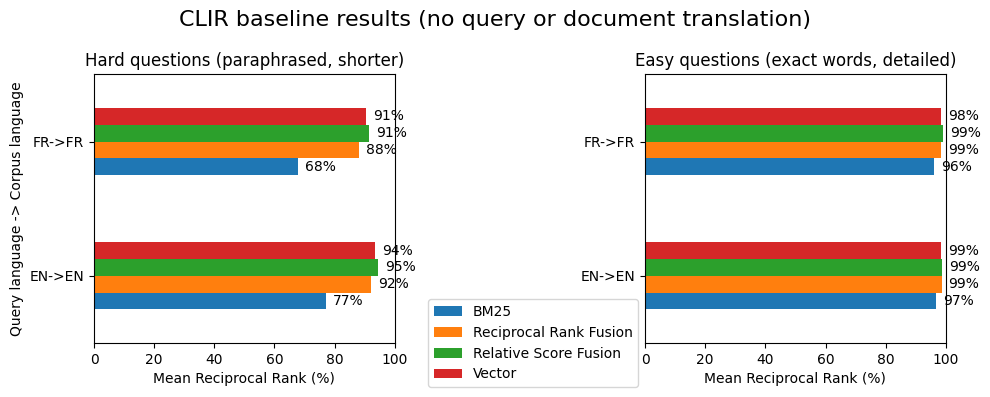

In [19]:
# Same as above but horizontal bar charts
# Twin plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data
data_hard.pivot_table(
    index=['Query language', 'Corpus language'], 
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='barh', ax=ax[0])

data_easy.pivot_table(
    index=['Query language', 'Corpus language'],
    columns='Retriever', 
    values='Mean Reciprocal Rank'
).plot(kind='barh', ax=ax[1])

# Annotate each bar with the value, moving the text inside the right edge of the bar
for a in [ax[0], ax[1]]:
    for p in a.patches:
        a.annotate(
            f"{p.get_width():.0f}%",
            (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
            ha="left",
            va="center",
            xytext=(5, 0),
            textcoords="offset points",
        )

ax[0].set_xlabel('Mean Reciprocal Rank (%)')
ax[1].set_xlabel('Mean Reciprocal Rank (%)')

# Set the x-axis from 0 to 100 on both plots
ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)

# Set the title and labels
ax[0].set_title('Hard questions (paraphrased, shorter)')
ax[0].set_ylabel('Query language -> Corpus language')

ax[1].set_title('Easy questions (exact words, detailed)')
ax[1].set_ylabel('')

ax[0].set_yticklabels(["FR->FR", "EN->EN", ][::-1])
ax[1].set_yticklabels(["FR->FR", "EN->EN", ][::-1])

# Move the legend outside the right plot. Remove the left legend.
ax[1].legend(loc='center right', bbox_to_anchor=(0, 0))
ax[0].legend().remove()

# Set the overall title
fig.suptitle('CLIR baseline results (no query or document translation)', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()

## Postgres text search

We know this stinks, but how bad?

In [4]:

import psycopg2
from dotenv import load_dotenv
from psycopg2 import sql
from sqlalchemy import make_url

from llama_index.vector_stores.postgres import PGVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core import Settings
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.retrievers import QueryFusionRetriever

Settings.chunk_size = 1024

DB_NAME = os.environ.get("DB_NAME", "llama_index")
DB_USER = os.environ.get("DB_USER", "postgres")
DB_PASSWORD = os.environ.get("DB_PASSWORD", "password")
DB_HOST = os.environ.get("DB_HOST", "localhost")
DB_PORT = os.environ.get("DB_PORT", "5432")

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}"
url = make_url(connection_string)

vector_store = PGVectorStore.from_params(
    database=DB_NAME,
    host=url.host,
    password=url.password,
    port=url.port,
    user=url.username,
    table_name="test_hybrid",
    embed_dim=1536,
    perform_setup=True,
    hybrid_search=True,
    text_search_config="simple",
    debug=False,
    use_jsonb=True,
)

In [ ]:

eng_index = VectorStoreIndex.from_vector_store(vector_store=vector_store, show_progress=True)
eng_index.insert_nodes(eng_nodes)

eng_vector_retriever = eng_index.as_retriever(
    vector_store_query_mode="default",
    similarity_top_k=5,
)
eng_text_retriever = eng_index.as_retriever(
    vector_store_query_mode="sparse",
    similarity_top_k=5,
)
eng_retriever = QueryFusionRetriever(
    retrievers=[eng_vector_retriever, eng_text_retriever],
    mode="relative_score",
    llm=service_context.llm,
    similarity_top_k=5,
    num_queries=1,
    use_async=False,
    retriever_weights=[0.7, 0.3],
)

In [13]:
fra_index = VectorStoreIndex.from_vector_store(vector_store=vector_store, show_progress=True)
fra_index.insert_nodes(fra_nodes)

fra_vector_retriever = fra_index.as_retriever(
    vector_store_query_mode="default",
    similarity_top_k=5,
)
fra_text_retriever = fra_index.as_retriever(
    vector_store_query_mode="sparse",
    similarity_top_k=5,
)
fra_retriever = QueryFusionRetriever(
    retrievers=[fra_vector_retriever, fra_text_retriever],
    mode="relative_score",
    llm=service_context.llm,
    similarity_top_k=5,
    num_queries=1,
    use_async=False,
    retriever_weights=[0.7, 0.3],
)

In [15]:
from llama_index.core.evaluation import RetrieverEvaluator

import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    columns = {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}

    # if include_cohere_rerank:
    #     crr_relevancy = full_df["cohere_rerank_relevancy"].mean()
    #     columns.update({"cohere_rerank_relevancy": [crr_relevancy]})

    metric_df = pd.DataFrame(columns)

    return metric_df

metrics = ["mrr", "hit_rate"]

eng_text_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_text_retriever
)
fra_text_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_text_retriever
)
eng_pghybrid_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_retriever
)
fra_pghybrid_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_retriever
)

In [16]:

import time

start = time.time()
eng_to_eng_hard_text = await eng_text_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_text = await fra_text_evaluator.aevaluate_dataset(fra_to_fra_hard)
eng_to_eng_hard_hybrid = await eng_pghybrid_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_hybrid = await fra_pghybrid_evaluator.aevaluate_dataset(fra_to_fra_hard)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

result1 = display_results("eng_pgtext_retriever", eng_to_eng_hard_text)
result1["test_set"] = "eng_to_eng_hard"
result2 = display_results("eng_pghybrid_retriever", eng_to_eng_hard_hybrid)
result2["test_set"] = "eng_to_eng_hard"
result4 = display_results("fra_pgtext_retriever", fra_to_fra_hard_text)
result4["test_set"] = "fra_to_fra_hard"
result5 = display_results("fra_pghybrid_retriever", fra_to_fra_hard_hybrid)
result5["test_set"] = "fra_to_fra_hard"

result = pd.concat([result1, result2, result4, result5])
result

sys:1: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)


Time taken: 220.06 seconds


,retrievers,hit_rate,mrr,test_set
0,eng_pgtext_retriever,0.513,0.397950,eng_to_eng_hard
0,eng_pghybrid_retriever,0.978,0.934600,eng_to_eng_hard
0,fra_pgtext_retriever,0.265,0.200933,fra_to_fra_hard
0,fra_pghybrid_retriever,0.955,0.904900,fra_to_fra_hard


In [17]:
# Same thing for easy questions
start = time.time()
eng_to_eng_easy_text = await eng_text_evaluator.aevaluate_dataset(eng_to_eng_easy)
fra_to_fra_easy_text = await fra_text_evaluator.aevaluate_dataset(fra_to_fra_easy)
eng_to_eng_easy_hybrid = await eng_pghybrid_evaluator.aevaluate_dataset(eng_to_eng_easy)
fra_to_fra_easy_hybrid = await fra_pghybrid_evaluator.aevaluate_dataset(fra_to_fra_easy)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

result1 = display_results("eng_pgtext_retriever", eng_to_eng_easy_text)
result1["test_set"] = "eng_to_eng_easy"
result2 = display_results("eng_pghybrid_retriever", eng_to_eng_easy_hybrid)
result2["test_set"] = "eng_to_eng_easy"
result4 = display_results("fra_pgtext_retriever", fra_to_fra_easy_text)
result4["test_set"] = "fra_to_fra_easy"
result5 = display_results("fra_pghybrid_retriever", fra_to_fra_easy_hybrid)
result5["test_set"] = "fra_to_fra_easy"

result = pd.concat([result, result1, result2, result4, result5])
result

sys:1: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)


Time taken: 289.06 seconds


,retrievers,hit_rate,mrr,test_set
0,eng_pgtext_retriever,0.513,0.397950,eng_to_eng_hard
0,eng_pghybrid_retriever,0.978,0.934600,eng_to_eng_hard
0,fra_pgtext_retriever,0.265,0.200933,fra_to_fra_hard
0,fra_pghybrid_retriever,0.955,0.904900,fra_to_fra_hard
0,eng_pgtext_retriever,0.835,0.740150,eng_to_eng_easy
0,eng_pghybrid_retriever,1.000,0.989117,eng_to_eng_easy
0,fra_pgtext_retriever,0.498,0.394283,fra_to_fra_easy
0,fra_pghybrid_retriever,0.996,0.981500,fra_to_fra_easy


In [18]:
# Nicer labels for the results
column_mapping = {
    "retrievers": "Retriever",
    "hit_rate": "Hit Rate",
    "mrr": "Mean Reciprocal Rank",
    "test_set": "Queries",
}
value_mapping = {
    "fra_pgtext_retriever": "PG text (French)",
    "eng_pgtext_retriever": "PG text (English)",
    "fra_pghybrid_retriever": "PG hybrid (French)",
    "eng_pghybrid_retriever": "PG hybrid (English)",
    "eng_to_eng_easy": "English (Easy)",
    "eng_to_eng_hard": "English (Hard)",
    "fra_to_fra_easy": "French (Easy)",
    "fra_to_fra_hard": "French (Hard)",
    "eng_to_fra_easy": "English (Easy)",
    "eng_to_fra_hard": "English (Hard)",
    "fra_to_eng_easy": "French (Easy)",
    "fra_to_eng_hard": "French (Hard)",
}

result_cross2 = result.rename(columns=column_mapping)
result_cross2 = result_cross2.replace(value_mapping)

# Split the columns so that "BM25 (French)" becomes two columns: "Retriever: BM25" and "Corpus language: French"
result_cross2["Corpus language"] = result_cross2["Retriever"].str.split(" \(").str[1].str[:-1]
result_cross2["Retriever"] = result_cross2["Retriever"].str.split(" \(").str[0]

# Split the columns so that "English (Easy)" becomes two columns: "Query language: English" and "Query difficulty: Easy"
result_cross2["Query language"] = result_cross2["Queries"].str.split(" \(").str[0]
result_cross2["Query difficulty"] = result_cross2["Queries"].str.split(" \(").str[1].str[:-1]

result_cross2 = result_cross2[
    ['Corpus language', 'Query language', 'Query difficulty', 'Retriever', 'Hit Rate', 'Mean Reciprocal Rank']
].sort_values(by=['Corpus language', 'Query language', 'Query difficulty', 'Retriever'])

result_cross2.reset_index(inplace=True, drop=True)
result_cross2

,Corpus language,Query language,Query difficulty,Retriever,Hit Rate,Mean Reciprocal Rank
0,English,English,Easy,PG hybrid,1.000,0.989117
1,English,English,Easy,PG text,0.835,0.740150
2,English,English,Hard,PG hybrid,0.978,0.934600
3,English,English,Hard,PG text,0.513,0.397950
4,French,French,Easy,PG hybrid,0.996,0.981500
5,French,French,Easy,PG text,0.498,0.394283
6,French,French,Hard,PG hybrid,0.955,0.904900
7,French,French,Hard,PG text,0.265,0.200933


## Qdrant: Hybrid SPLADE (sparse) & OpenAI large embeddings

Truncate to 1024 dimensions because it seems not to matter basically at all, for English and French text (native dimension is less than 1% better, but 3x the size)

In [5]:
import nest_asyncio

nest_asyncio.apply()

In [6]:
from qdrant_client import QdrantClient, AsyncQdrantClient

# creates a persistent index to disk
client = AsyncQdrantClient(path=".qdrant")

embed_model = AzureOpenAIEmbedding(
    model="text-embedding-3-large",
    deployment_name="text-embedding-3-large",
    dimensions=1024,
    embed_batch_size=16,
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

service_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model=embed_model,
)

set_global_service_context(service_context)

eng_qdrant_vector_store = QdrantVectorStore(
    "eng_qdrant_test", aclient=client, enable_hybrid=True, batch_size=16
)
eng_index = VectorStoreIndex.from_vector_store(vector_store=eng_qdrant_vector_store, show_progress=True)
# eng_index.insert_nodes(eng_nodes)

eng_splade_retriever = eng_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    sparse_top_k=5,
    alpha=0,  # Qdrant uses 0 for sparse, 1 for dense
)

eng_qdrant_retriever = eng_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    sparse_top_k=5,
    alpha=0.5,  # Qdrant uses 0 for sparse, 1 for dense
)

C:\Users\jkuehn\AppData\Local\Temp\ipykernel_147840\2458676484.py:16: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


In [7]:
fra_qdrant_vector_store = QdrantVectorStore(
    "fra_qdrant_test", aclient=client, enable_hybrid=True, batch_size=64
)
fra_index = VectorStoreIndex.from_vector_store(vector_store=fra_qdrant_vector_store, show_progress=True)
# fra_index.insert_nodes(fra_nodes)

fra_splade_retriever = fra_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    sparse_top_k=5,
    alpha=0,  # Qdrant uses 0 for sparse, 1 for dense
)

fra_qdrant_retriever = fra_index.as_retriever(
    vector_store_query_mode="hybrid",
    similarity_top_k=5,
    sparse_top_k=5,
    alpha=0.5,  # Qdrant uses 0 for sparse, 1 for dense
)

In [8]:
from llama_index.core.evaluation import RetrieverEvaluator

import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""
    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)
    full_df = pd.DataFrame(metric_dicts)
    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    columns = {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}
    metric_df = pd.DataFrame(columns)
    return metric_df

metrics = ["mrr", "hit_rate"]

eng_splade_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_splade_retriever
)
fra_splade_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_splade_retriever
)
eng_qdrant_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=eng_qdrant_retriever
)
fra_qdrant_evaluator = RetrieverEvaluator.from_metric_names(
    metrics, retriever=fra_qdrant_retriever
)

In [9]:

import time

start = time.time()
eng_to_eng_hard_splade = await eng_splade_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_splade = await fra_splade_evaluator.aevaluate_dataset(fra_to_fra_hard)
eng_to_eng_hard_qdrant = await eng_qdrant_evaluator.aevaluate_dataset(eng_to_eng_hard)
fra_to_fra_hard_qdrant = await fra_qdrant_evaluator.aevaluate_dataset(fra_to_fra_hard)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

# result1 = display_results("eng_pgtext_retriever", eng_to_eng_hard_text)
# result1["test_set"] = "eng_to_eng_hard"
# result2 = display_results("eng_pghybrid_retriever", eng_to_eng_hard_hybrid)
# result2["test_set"] = "eng_to_eng_hard"
# result4 = display_results("fra_pgtext_retriever", fra_to_fra_hard_text)
# result4["test_set"] = "fra_to_fra_hard"
# result5 = display_results("fra_pghybrid_retriever", fra_to_fra_hard_hybrid)
# result5["test_set"] = "fra_to_fra_hard"
result1 = display_results("eng_splade_retriever", eng_to_eng_hard_splade)
result1["test_set"] = "eng_to_eng_hard"
result2 = display_results("eng_qdrant_retriever", eng_to_eng_hard_qdrant)
result2["test_set"] = "eng_to_eng_hard"
result4 = display_results("fra_splade_retriever", fra_to_fra_hard_splade)
result4["test_set"] = "fra_to_fra_hard"
result5 = display_results("fra_qdrant_retriever", fra_to_fra_hard_qdrant)
result5["test_set"] = "fra_to_fra_hard"

result = pd.concat([result1, result2, result4, result5])
result

CancelledError: 

## Final comparison

In [4]:
result_df = pd.read_csv("./pg-results.csv")

Text(0.5, 1.0, 'Hit Rate for English queries (hard)')

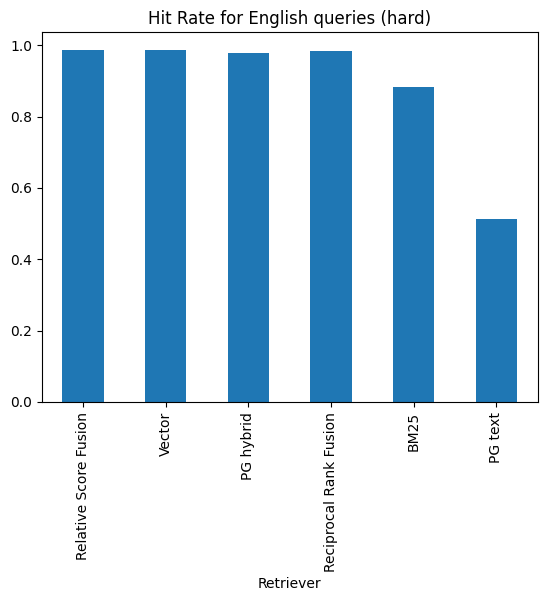

In [14]:
eng_results = result_df[
    (result_df["Corpus language"] == result_df["Query language"])
    &
    (result_df["Query difficulty"] == "Hard")
    &
    result_df["Corpus language"].str.contains("English")
].sort_values(by="Mean Reciprocal Rank", ascending=False)
eng_results.set_index("Retriever", inplace=True)
eng_results["Hit Rate"].plot.bar()
plt.title("Hit Rate for English queries (hard)")

Text(0.5, 1.0, 'Mean Reciprocal Rank for English queries (hard)')

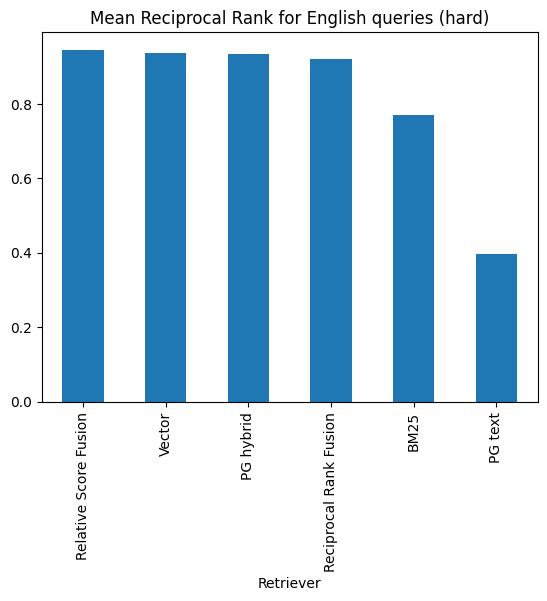

In [15]:
eng_results["Mean Reciprocal Rank"].plot.bar()
plt.title("Mean Reciprocal Rank for English queries (hard)")

In [16]:
eng_results

,Corpus language,Query language,Query difficulty,Hit Rate,Mean Reciprocal Rank
Retriever,,,,,
Relative Score Fusion,English,English,Hard,0.987,0.945250
Vector,English,English,Hard,0.986,0.935700
PG hybrid,English,English,Hard,0.978,0.934600
Reciprocal Rank Fusion,English,English,Hard,0.985,0.920600
BM25,English,English,Hard,0.884,0.771383
PG text,English,English,Hard,0.513,0.397950
